In [2]:
import os
import json
import torch
torch.set_grad_enabled(False)
import numpy as np
from pprint import pprint
import sys
sys.path.append('../..')
from nebula.models.attention import TransformerEncoderModel, TransformerEncoderChunks
from nebula import PEDynamicFeatureExtractor
from nebula.preprocessing import JSONTokenizerNaive, JSONTokenizerBPE
from nebula.misc import get_path, clear_cuda_cache, set_random_seed
from nebula.constants import *
from bertviz import model_view, head_view
from collections import Counter

from tqdm import tqdm
DEVICE = "cuda"

SCRIPT_PATH = get_path(type="notebook")
ROOT = os.path.join(SCRIPT_PATH, "..", "..")


In [3]:
# done three folds on that run
MODEL_IDX = 1

# BPE
datafolder = os.path.join(ROOT, r"evaluation\paper_sota\out_speakeasy\nebula_speakeasy_vocab_50000_seqlen_512")
model_folder = os.path.join(ROOT, r"evaluation\paper_sota\out_speakeasy\cv_nebula_limNone_r1763_t20\training_files")

# Whitespace
# datafolder = os.path.join(ROOT, r"evaluation\paper_ablation\out_tokenizer\nebula_whitespace_vocab_50000_seqlen_512")
# model_folder = os.path.join(ROOT, r"evaluation\paper_ablation\out_tokenizer\cv_whitespace_limNone_r1763_t5\training_files")

# LOADING OBJECTS
model_file = [x for x in os.listdir(model_folder) if x.endswith(".torch")][MODEL_IDX]
model_file_fullpath = os.path.join(model_folder, model_file)
state_dict = torch.load(model_file_fullpath)

with open(os.path.join(datafolder, f"tokenizer_50000_vocab.json")) as f:
    nebula_vocab = json.load(f)

# BPE
tokenizer = JSONTokenizerBPE(
    vocab_size=len(nebula_vocab),
    seq_len=512,
    model_path=os.path.join(ROOT, datafolder, r"tokenizer_50000.model")
)

# Whitespace
# tokenizer = JSONTokenizerNaive(
#     vocab_size=len(nebula_vocab),
#     seq_len=512,
#     vocab=nebula_vocab
# )

model_config = {
        "vocab_size": len(nebula_vocab),
        "maxlen": 512,
        "chunk_size": 64,
        "dModel": 64,  # embedding & transformer dimension
        "nHeads": 8,  # number of heads in nn.MultiheadAttention
        "dHidden": 256,  # dimension of the feedforward network model in nn.TransformerEncoder
        "nLayers": 2,  # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
        "numClasses": 1, # binary classification
        "hiddenNeurons": [64],
        "layerNorm": False,
        "dropout": 0.3,
        "mean_over_sequence": False,
        "norm_first": True
    }
model = TransformerEncoderChunks(**model_config)
model.load_state_dict(state_dict)
_ = model.to(DEVICE)


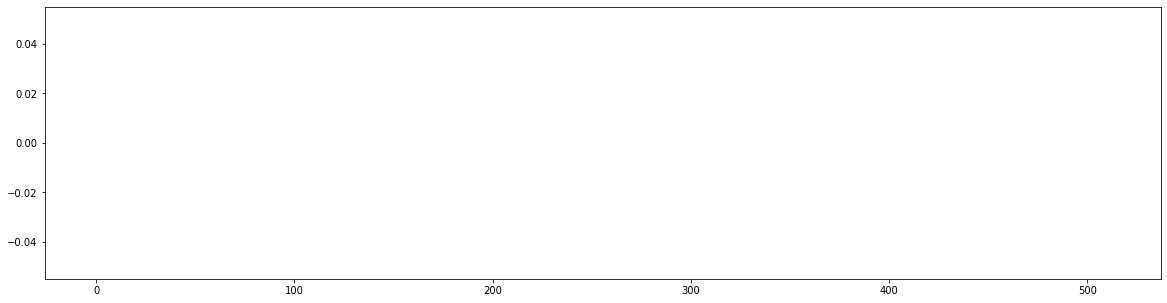

In [20]:
DEVICE = "cpu"
import torch.nn as nn
from copy import deepcopy
import shap

class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x


# build two models -- one for getting embed, other for SHAP (w/o embeddings)
model = TransformerEncoderChunks(**model_config).to(DEVICE)
model.load_state_dict(state_dict)

model_no_embed = deepcopy(model)
model_no_embed.encoder = Identity()


# load sample
report_root = os.path.join(ROOT, r"data\data_raw\windows_emulation_trainset\report_backdoor")
exampleFile = os.path.join(report_root, "0009064322cdc719a82317553b805cbbc64230a9212d3b8aad1ea1b78d3bf10a.json")
with open(exampleFile) as f:
    exampleFile = json.load(f)

extractor = PEDynamicFeatureExtractor()
exampleProcessed = extractor.filter_and_normalize_report(exampleFile)
exampleTokenized = tokenizer.tokenize(exampleProcessed)
exampleEncoded = tokenizer.encode(exampleProcessed)
x = torch.Tensor(exampleEncoded).long().reshape(1,-1).to(DEVICE)
x = x[:, :512]
x_embed = model.encoder(x.long()).float()

def analyze_feature_importance_shap(model, x):
    explainer = shap.DeepExplainer(model, x)
    shap_values = explainer.shap_values(x)
    return shap_values

import matplotlib.pyplot as plt
def plot_shap(shap_values, x):
    # plot
    plt.figure(figsize=(20,5))
    plt.bar(range(len(shap_values)), shap_values)

shap_values = analyze_feature_importance_shap(model_no_embed, x_embed.requires_grad_())

plot_shap(shap_values[0].mean(axis=1), x_embed.numpy()[0].mean(axis=1))

In [26]:
a = shap_values[0].mean(axis=1)
# return elements in a that are not 0
a[a != 0]

array([], dtype=float64)